# Building an end-to-end Speech Recognition model in PyTorch - [AssemblyAI](https://www.assemblyai.com/)

## installing the requirements

In [1]:
#!pip install torchaudio==0.4.0 torch==1.4.0 comet-ml==3.0.2
!pip install torchaudio torch comet-ml
#!pip install torch==2.1.0

  Using cached comet_ml-3.47.4-py3-none-any.whl.metadata (3.9 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nc

In [1]:
import torch
import torchaudio

print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("TorchAudio version:", torchaudio.__version__)

Torch version: 2.1.0+cu121
CUDA version: 12.1
TorchAudio version: 2.1.0+cu121


## Setting up your data pipeline

In [2]:
import os
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import pandas as pd

def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)

def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]

def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

class TextTransform:
    """Maps lexicon-based phonetic symbols to integers and vice versa."""
    def __init__(self, lexicon_path):
        self.char_map = {}
        self.index_map = {}
        self.blank_index = None  # 初始化空白字符索引

        # 讀取 lexicon 檔案
        with open(lexicon_path, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                print(f"Raw line: {repr(line.strip())}")
                if len(parts) >= 2:
                    symbol = parts[0]
                    if symbol not in self.char_map:
                        index = len(self.char_map)
                        self.char_map[symbol] = index
                        self.index_map[index] = symbol
                
                elif parts[0] == "<SIL>":  # 如果符號是 <SIL>
                    self.blank_index = len(self.char_map)
                    self.char_map["<SIL>"] = self.blank_index
                    self.index_map[self.blank_index] = "<SIL>"
                #print(f'char_map：{self.char_map[symbol]}, index_map：{self.index_map[index]}')

        # 如果未找到 <SIL>，設定默認空白字符索引
        if self.blank_index is None:
            self.blank_index = len(self.char_map)
            self.char_map["<BLANK>"] = self.blank_index
            self.index_map[self.blank_index] = "<BLANK>"
        print(f"Char map keys: {list(self.char_map)}")  # 查看前 10 個鍵值
        print(f"index_map keys: {list(self.index_map)}")  # 查看前 10 個鍵值
        #print(f"Blank index: {text_transform.blank_index}")

    def text_to_int(self, text):
        """
        將輸入文本轉換為整數序列，添加檢查
        """
        int_sequence = []
        for token in text.split():
            if token in self.char_map:
                int_sequence.append(self.char_map[token])
            else:
                print(f"Warning: 未知符號 '{token}' 未在 lexicon 中定義")
        if len(int_sequence) == 0:
            print(f"Error: 文本 '{text}' 無法轉換為整數序列")

        return int_sequence

    def int_to_text(self, labels):
        """將整數序列轉換回文本"""
        return ' '.join([self.index_map[i] for i in labels if i in self.index_map])

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128, win_length=400, hop_length=160),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

print(f'train_audio_transforms：{train_audio_transforms}')

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

lexicon_path = "/mnt/sda1/shuof/HW/Taiwaness/kaldi-taiwanese-asr/lexicon.txt"
text_transform = TextTransform(lexicon_path)
print(f"Char map: {text_transform.char_map}")  # 确认字符映射是否正确

def create_data_list(data_dir, labels_path):
    # 加載標籤檔案
    labels_df = pd.read_csv(labels_path)

    # 創建音檔與標籤的對應關係
    data_list = []
    for index, row in labels_df.iterrows():
        audio_path = os.path.join(data_dir, f"{row['id']}.wav")
        if os.path.exists(audio_path):
            data_list.append((audio_path, row['text']))  # 音檔路徑和正確答案
        else:
            print(f"音檔 {audio_path} 不存在，跳過")
    if len(data_list) == 0:
        print("Error: 無有效的音檔對應到文本!")
    return data_list

def data_processing(data, text_transform, data_type="train", visualize = False):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for audio_path, utterance in data:
        try:
            waveform, _ = torchaudio.load(audio_path)

            if data_type == 'train':
                spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            elif data_type == 'valid':
                spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            else:
                raise ValueError('data_type should be train or valid')
            
            spectrograms.append(spec)
            label = torch.Tensor(text_transform.text_to_int(utterance))
            labels.append(label)
            input_lengths.append(spec.shape[0] // 2)
            label_lengths.append(len(label))

            # Debug prints to verify feature sizes and label lengths
            print(f"Processed {audio_path}:")
            print(f"  Waveform shape: {waveform.shape}")
            print(f"  Spectrogram shape: {spec.shape}")
            print(f"  Label length: {len(label)}")

        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")

    # Padding and batch handling
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

def GreedyDecoder(output, labels, label_lengths, collapse_repeated=True):
    print("Decoder Input Shapes:")
    print(f"Output shape: {output.shape}, Labels shape: {labels.shape}, Label lengths: {label_lengths}")
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    blank_label = text_transform.blank_index  # 从 TextTransform 获取空白索引

    if output.numel() == 0:
        print("Error: 模型輸出為空，請檢查模型輸出流程")
    if torch.all(output == 0):
        print("Warning: 模型輸出全為零，可能需要檢查模型訓練或前向傳播邏輯")

    if torch.all(arg_maxes == text_transform.blank_index):
        print("Warning: 模型輸出僅包含空白符號，可能是訓練不足或輸入特徵問題")

    print(f"arg_maxes: {arg_maxes}")
    print(f"output: {output}")

    for i, args in enumerate(arg_maxes):
        decode = []
        # 檢查 label 的長度是否為 0，若為 0，跳過該條目
        if label_lengths[i] == 0:
            print(f"Skipping empty reference at index {i}")
            continue
        if labels[i].numel() == 0:
            print(f"Error: Label at index {i} is empty.")
            continue

        # 獲取參考文本
        target_text = text_transform.int_to_text(labels[i][:label_lengths[i]].tolist())
        if not target_text.strip():  # 檢查是否為空文本
            print(f"Empty reference at index {i}. Skipping.")
            continue
        

        # 添加目標文本到 targets
        targets.append(target_text)

        # 對輸出進行解碼
        for j, index in enumerate(args):
            if index != blank_label:  # 使用从 text_transform 获取的 blank_index
                if collapse_repeated and j != 0 and index == args[j - 1]:
                    continue
                if index >= len(text_transform.index_map):
                    print(f"Warning: 解碼索引 {index} 超出詞彙表範圍")
                    continue
                decode.append(index.item())
                print(f"Predicted indices: {decode}")  # 打印解码的索引值
        if not decode:
            print(f"Warning: 解碼結果為空，輸出可能僅包含空白符號")
        
        decodes.append(text_transform.int_to_text(decode))
        
    if not decodes:
        print("Error: 所有解碼結果均為空，請檢查模型輸出、詞彙表或解碼器配置")
    if len(decodes) != len(targets):
        print(f"Warning: 解碼結果數量 ({len(decodes)}) 與參考文本數量 ({len(targets)}) 不一致")
        
    return decodes, targets

train_audio_transforms：Sequential(
  (0): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (1): FrequencyMasking()
  (2): TimeMasking()
)
Raw line: 'ah iNULL ah'
Raw line: 'ai iNULL ai'
Raw line: 'ainn iNULL ainn'
Raw line: 'a iNULL a'
Raw line: 'ak iNULL ak'
Raw line: 'am iNULL am'
Raw line: 'ang iNULL ang'
Raw line: 'an iNULL an'
Raw line: 'ann iNULL ann'
Raw line: 'ap iNULL ap'
Raw line: 'at iNULL at'
Raw line: 'au iNULL au'
Raw line: 'ba b a'
Raw line: 'bah b ah'
Raw line: 'bai b ai'
Raw line: 'bak b ak'
Raw line: 'ban b an'
Raw line: 'bang b ang'
Raw line: 'bat b at'
Raw line: 'bau b au'
Raw line: 'bauh b auh'
Raw line: 'be b e'
Raw line: 'beh b eh'
Raw line: 'bian b ian'
Raw line: 'biat b iat'
Raw line: 'biau b iau'
Raw line: 'bi b i'
Raw line: 'bih b ih'
Raw line: 'bik b ik'
Raw line: 'bin b in'
Raw line: 'bing b ing'
Raw line: 'bio b io'
Raw line: 'bit b it'
Raw line: 'biu b iu'
Raw line: 'bo b o'
Raw line: 'bok b ok'
Raw line: 'bong b ong'
Raw

/home/shuof/.conda/envs/test/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


/home/shuof/.conda/envs/test/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


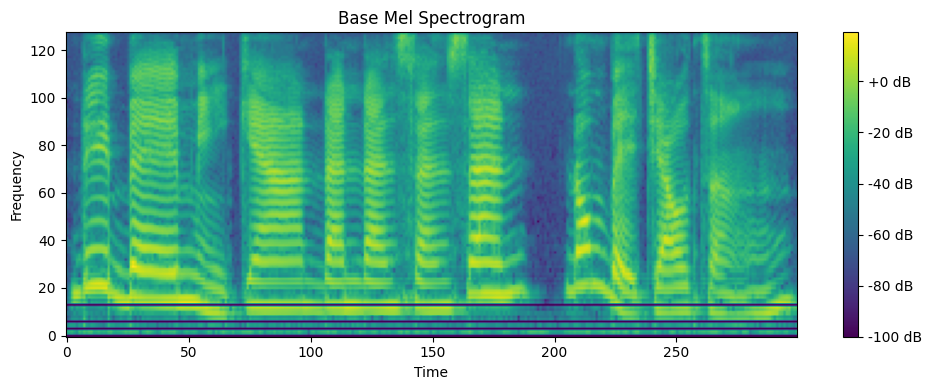

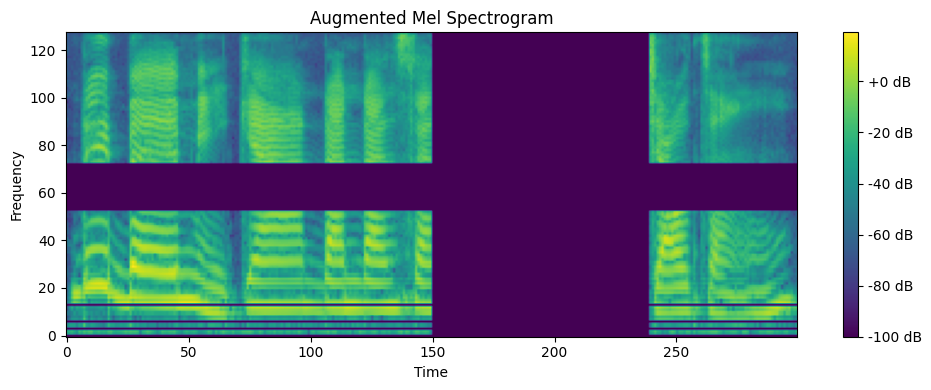

In [3]:
import torchaudio
import matplotlib.pyplot as plt
import torch.nn as nn

# 加载音频文件
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform, sample_rate

# 定义数据转换
def get_transforms():
    base_transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128)
    augmented_transform = nn.Sequential(
        torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
        torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
        torchaudio.transforms.TimeMasking(time_mask_param=100)
    )
    return base_transform, augmented_transform

# 生成Mel Spectrogram
def get_mel_spectrogram(waveform, transform):
    mel_spectrogram = transform(waveform)
    return mel_spectrogram

# 可视化Mel Spectrogram
def plot_mel_spectrogram(mel_spectrogram, title='Mel Spectrogram'):
    plt.figure(figsize=(10, 4))
    mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
    plt.imshow(mel_spectrogram_db[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# 示例使用
audio_path = '/mnt/sda1/shuof/HW/Taiwaness/kaldi-taiwanese-asr/processed_train/1.wav'  # 替换为你的音频文件路径
waveform, sample_rate = load_audio(audio_path)
base_transform, augmented_transform = get_transforms()

# 获取并可视化原始Mel Spectrogram
base_mel_spectrogram = get_mel_spectrogram(waveform, base_transform)
plot_mel_spectrogram(base_mel_spectrogram, 'Base Mel Spectrogram')

# 获取并可视化增强后的Mel Spectrogram
augmented_mel_spectrogram = get_mel_spectrogram(waveform, augmented_transform)
plot_mel_spectrogram(augmented_mel_spectrogram, 'Augmented Mel Spectrogram')

## The Model
Base of of Deep Speech 2 with some personal improvements

In [4]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)

class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x


## The Training and Evaluating Script

In [4]:
import gc

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [45]:
import os
import csv

def generate_predictions(model, test_dir, output_csv, text_transform, device):
    model.eval()  # 切換模型到評估模式
    predictions = []

    for i, file_name in enumerate(sorted(os.listdir(test_dir)), start=1):
        if file_name.endswith('.wav'):
            audio_path = os.path.join(test_dir, file_name)
            
            # 加載音檔
            waveform, _ = torchaudio.load(audio_path)
            waveform = waveform.to(device)
            
            # 預處理音檔
            spec = train_audio_transforms(waveform).unsqueeze(0)
            spec = spec.to(device)
            
            # 模型預測
            with torch.no_grad():
                output = model(spec)  # (time, batch, n_class)
                output = torch.nn.functional.log_softmax(output, dim=2)
                output = output.transpose(0, 1)  # (batch, time, n_class)
            
            # 解碼
            decoded_preds, _ = GreedyDecoder(output, torch.empty(0), torch.empty(0))  # labels 可忽略
            
            # 添加結果
            predictions.append({"id": i, "text": decoded_preds[0]})

    # 寫入到 CSV
    with open(output_csv, mode='w', encoding='utf-8') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=["id", "text"])
        writer.writeheader()
        writer.writerows(predictions)

    print(f"預測結果已保存到 {output_csv}")

In [5]:
from sklearn.model_selection import train_test_split

class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment):
    model.train()
    data_len = len(train_loader.dataset)
    with experiment.train():
        for batch_idx, _data in enumerate(train_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            loss.backward()

            experiment.log_metric('loss', loss.item(), step=iter_meter.get())
            experiment.log_metric('learning_rate', scheduler.get_lr(), step=iter_meter.get())

            optimizer.step()
            scheduler.step()
            iter_meter.step()
            if batch_idx % 100 == 0 or batch_idx == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(spectrograms), data_len,
                    100. * batch_idx / len(train_loader), loss.item()))



def test(model, device, test_loader, criterion, epoch, iter_meter, experiment):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with experiment.test():
        with torch.no_grad():
            for i, _data in enumerate(test_loader):
                spectrograms, labels, input_lengths, label_lengths = _data
                spectrograms, labels = spectrograms.to(device), labels.to(device)

                output = model(spectrograms)  # (batch, time, n_class)
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0, 1) # (time, batch, n_class)

                loss = criterion(output, labels, input_lengths, label_lengths)
                test_loss += loss.item() / len(test_loader)

                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

                # Print predictions and original labels for debugging
                for i in range(len(decoded_preds)):
                    print(f"Original: {decoded_targets[i]}")
                    print(f"Predicted: {decoded_preds[i]}")
                    
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    experiment.log_metric('test_loss', test_loss, step=iter_meter.get())
    experiment.log_metric('cer', avg_cer, step=iter_meter.get())
    experiment.log_metric('wer', avg_wer, step=iter_meter.get())

    print(f"Decoded predictions: {decoded_preds}")
    print(f"Original labels: {decoded_targets}")

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))


def main(learning_rate, batch_size, epochs, 
         data_dir="/mnt/sda1/shuof/HW/Taiwaness/kaldi-taiwanese-asr/processed_train",
         csv_path="/mnt/sda1/shuof/HW/Taiwaness/kaldi-taiwanese-asr/train-toneless.csv",
         experiment=Experiment(api_key='dummy_key', disabled=True)):

    # 加载数据并切分为训练集和测试集
    data_list = create_data_list(data_dir, csv_path)

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 256,
        "n_class": len(text_transform.char_map),
        "n_feats": 128,
        "stride": 2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    experiment.log_parameters(hparams)

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_data,
                                   batch_size=hparams['batch_size'],
                                   shuffle=True,
                                   collate_fn=lambda x: data_processing(x, text_transform, 'train'),
                                   **kwargs)
    test_loader = data.DataLoader(dataset=test_data,
                                  batch_size=hparams['batch_size'],
                                  shuffle=False,
                                  collate_fn=lambda x: data_processing(x, text_transform,'valid'),
                                  **kwargs)

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    ).to(device)

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=text_transform.blank_index).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'],
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=hparams['epochs'],
                                              anneal_strategy='linear')

    iter_meter = IterMeter()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment)
        test(model, device, test_loader, criterion, epoch, iter_meter, experiment)
        #clear_memory()

    # 測試預測並生成 CSV
    #test_dir = "/mnt/sda1/shuof/HW/Taiwaness/kaldi-taiwanese-asr/processed_test"
    #output_csv = "sample.csv"
    #generate_predictions(model, test_dir, output_csv, text_transform, device)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


## Setting up Comet
If you have a comet account, fill in teh api key, project name and experiment name below. You can create an account at [comet.ml](comet.ml).

In [6]:
comet_api_key = "" # add your api key here
project_name = "speechrecognition"
experiment_name = "speechrecognition-colab"

if comet_api_key:
  experiment = Experiment(api_key=comet_api_key, project_name=project_name, parse_args=False)
  experiment.set_name(experiment_name)
  experiment.display()
else:
  experiment = Experiment(api_key='dummy_key', disabled=True)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


## GPU runtime
If you are using a GPU runtime, this will let you know what GPU and how much memory is available. Adjust your batch_size depending on which GPU

In [7]:
!nvidia-smi

Sun Dec 22 00:08:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:04:00.0 Off |                  N/A |
|  0%   44C    P8             20W /  340W |    9505MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
import torch

# 清除 CUDA 空閒記憶體
torch.cuda.empty_cache()

In [13]:
import gc

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

clear_memory()

In [14]:
# 查看目前分配的記憶體（以 MB 為單位）
print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2} MB")
print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2} MB")

Allocated memory: 101.05810546875 MB
Cached memory: 114.0 MB


## Train
this will download the data on first run and may take a while.

If you have Comet.ml setup, you can start seeing your progress in the comet cell above.

In [15]:
learning_rate = 5e-2
batch_size = 8
epochs = 3

main(learning_rate, batch_size, epochs)

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 9.68 GiB of which 5.56 MiB is free. Process 3412222 has 9.26 GiB memory in use. Including non-PyTorch memory, this process has 398.00 MiB memory in use. Of the allocated memory 126.61 MiB is allocated by PyTorch, and 9.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
experiment.end()